<a href="https://colab.research.google.com/github/AbdoulayeDiop/plant-classification-with-pretrained-ResNet50/blob/main/plant_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# urls = [
#     f"https://www.cvl.isy.liu.se/en/research/datasets/swedish-leaf/leaf{i}.zip" \
#     for i in range(1, 16)
# ]

# with open("urls.txt", "w") as f:
#   for url in urls:
#     f.write(f"{url}\n")

In [3]:
# !mkdir downloads
# !wget -i urls.txt -P downloads/
# !unzip 'downloads/*.zip' -d drive/MyDrive/Datasets/SwedishLeaf/

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from torchvision import datasets, transforms
from PIL import Image

IMG_DIR = "drive/MyDrive/Datasets/SwedishLeaf/"
class_names = {
    1: "Ulmus carpinifolia",
    2: "Acer",
    3: "Salix aurita",
    4: "Quercus",
    5: "Alnus incana",
    6: "Betula pubescens",
    7: "Salix alba - Sericea",
    8: "Populus tremula",
    9: "Ulmus glabra",
    10: "Sorbus aucuparia",
    11: "Salix sinerea",
    12: "Populus",
    13: "Tilia",
    14: "Sorbus intermedia",
    15: "Fagus silvatica"
}

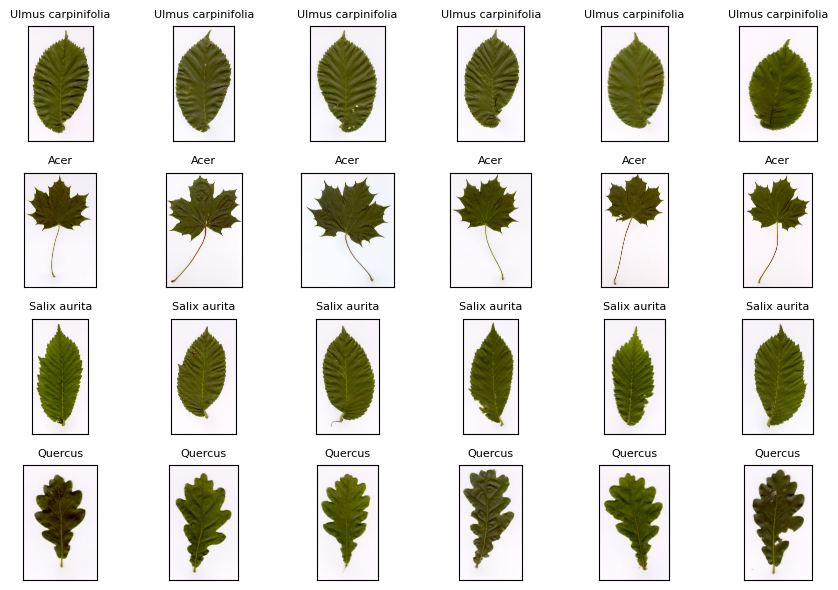

In [5]:
nrows = 4
ncols = 6
plt.figure(figsize=(ncols*1.5, nrows*1.5))
for row in range(nrows):
  leaf_class = row + 1
  class_name = class_names[leaf_class]
  for col in range(ncols):
    plt.subplot(nrows, ncols, row*ncols + col + 1)
    img_number = col + 1
    img = plt.imread(os.path.join(IMG_DIR, f"{leaf_class}/l{leaf_class}nr{img_number:03d}.tif"))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.title(class_name, fontsize=8)
plt.tight_layout()
plt.show()

In [6]:
re.split("[ln]", "l10nr003.tif")

['', '10', 'r003.tif']

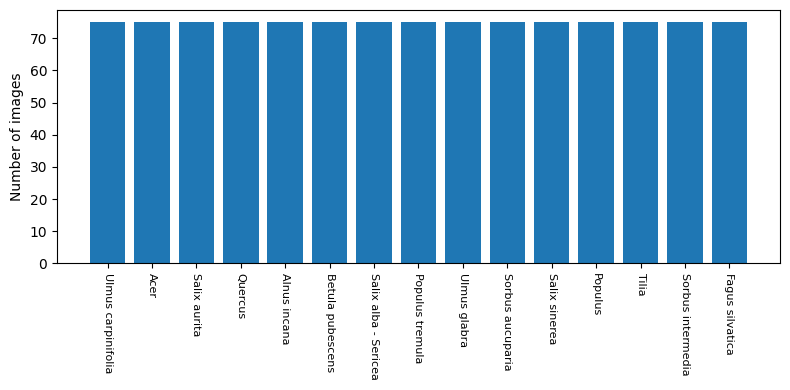

In [7]:
plt.figure(figsize=(8, 4))
all_imgs = os.listdir(IMG_DIR)
class_counts = {i: len(os.listdir(os.path.join(IMG_DIR, str(i)))) for i in class_names}

plt.bar(class_names.values(), class_counts.values())
plt.ylabel("Number of images")
plt.xticks(rotation=-90, fontsize=8)
plt.tight_layout()
plt.show()

In [8]:
import torch
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"
device

'cuda:0'

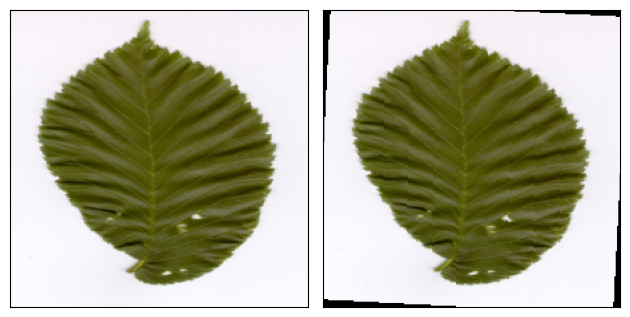

In [9]:
original_img = Image.open(os.path.join(IMG_DIR, f"1/l1nr003.tif"))
resized_img = transforms.Resize((224, 224))(original_img)
transformed_img = transforms.RandomRotation(180)(resized_img)
imgs = [resized_img, transformed_img]

nrows = 1
ncols = len(imgs)
for col, img in enumerate(imgs):
  plt.subplot(nrows, ncols, col + 1)
  plt.imshow(np.asarray(img))
  plt.xticks([])
  plt.yticks([])
plt.tight_layout()
plt.show()

In [10]:
from torchvision.models import resnet50, ResNet50_Weights
def get_resnet50():
  model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
  model.fc = torch.nn.Linear(model.fc.in_features, 15)
  torch.nn.init.xavier_uniform_(model.fc.weight)
  return model

In [11]:
def finetune(model, epochs, train_dataloader, optimizer, loss_function, val_dataloader=None, checkpoint_epochs=5, max_epochs_without_imp=2):
  history = {
      "loss": {
          "train": [],
          "val": []
      },
      "accuracy": {
          "train": [],
          "val": []
      }
  }
  epochs_without_imp = 0
  for epoch in range(1, epochs+1):
    print(f"Epoch {epoch}/{epochs}", end="\t-\t")

    model.train()  # put network in train mode for Dropout and Batch Normalization
    train_loss = torch.tensor(0., device=device)  # loss and accuracy tensors are on the GPU to avoid data transfers
    train_accuracy = torch.tensor(0., device=device)
    for X, y in train_dataloader:
      X = X.to(device)
      y = y.to(device)
      ypred = model(X)
      loss = loss_function(ypred, y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      with torch.no_grad():
        train_loss += loss*train_dataloader.batch_size
        train_accuracy += (torch.argmax(ypred, dim=1) == y).sum()

    history["loss"]["train"].append(train_loss.item()/len(train_dataloader.dataset))
    history["accuracy"]["train"].append(train_accuracy.item()/len(train_dataloader.dataset))
    print(f"train loss: {history['loss']['train'][-1]:.2f}", end=", ")
    print(f"train acc: {history['accuracy']['train'][-1]:.2f}", end="\t-\t")

    if val_dataloader is not None:
      model.eval()
      val_loss = torch.tensor(0., device=device)
      val_accuracy = torch.tensor(0., device=device)
      for X, y in val_dataloader:
        X = X.to(device)
        y = y.to(device)
        ypred = model(X)
        loss = loss_function(ypred, y)
        with torch.no_grad():
          val_loss += loss * val_dataloader.batch_size
          val_accuracy += (torch.argmax(ypred, dim=1) == y).sum()

      history["loss"]["val"].append(val_loss.item()/len(val_dataloader.dataset))
      history["accuracy"]["val"].append(val_accuracy.item()/len(val_dataloader.dataset))
      print(f"val loss: {history['loss']['val'][-1]:.2f}", end=", ")
      print(f"val acc: {history['accuracy']['val'][-1]:.2f}")
    if epoch % checkpoint_epochs == 0:
      torch.save({
          'epoch': epoch,
          'state_dict': model.state_dict(),
          'optimizer': optimizer.state_dict(),
      }, './checkpoint.pth.tar')

    if epoch >= 2 and history["loss"]["train"][-1] >= history["loss"]["train"][-2]:
      epochs_without_imp += 1
    if epochs_without_imp > max_epochs_without_imp:
      break

  return model, history


In [12]:
transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.RandomRotation(180),
                                transforms.ToTensor()])
dataset = datasets.ImageFolder(IMG_DIR, transform=transform)
train_set, val_set, test_set = torch.utils.data.random_split(dataset, (0.8, 0.1, 0.1))

In [13]:
# from time import time
# import multiprocessing as mp
# for num_workers in range(2, 16, 2):
#   train_loader = torch.utils.data.DataLoader(train_set,shuffle=True,num_workers=num_workers,batch_size=64,pin_memory=True)
#   start = time()
#   for epoch in range(1, 3):
#       for i, data in enumerate(train_loader, 0):
#           pass
#   end = time()
#   print("Finish with:{} second, num_workers={}".format(end - start, num_workers))

In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)

lr, weight_decay, epochs = 1e-3, 1e-3, 30
model = get_resnet50().to(device)
optimizer = torch.optim.Adam(model.fc.parameters(), lr=lr, weight_decay=weight_decay)
loss_function = torch.nn.CrossEntropyLoss()
finetune(model, epochs, train_dataloader, optimizer, loss_function, val_dataloader=val_dataloader)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 1/30	-	train loss: 2.58, train acc: 0.31	-	val loss: 2.41, val acc: 0.48
Epoch 2/30	-	train loss: 1.88, train acc: 0.82	-	